# **1. Setting**

In [2]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from google.colab.patches import cv2_imshow

In [3]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     |████████████████████████████████| 133 kB 5.4 MB/s 


In [1]:
!git clone https://github.com/Jaeyoon-Park/project02
%cd project02

Cloning into 'project02'...
remote: Enumerating objects: 5044, done.
remote: Counting objects: 100% (5044/5044), done.
remote: Compressing objects: 100% (5044/5044), done.
remote: Total 5044 (delta 0), reused 5044 (delta 0), pack-reused 0
Receiving objects: 100% (5044/5044), 640.93 MiB | 29.72 MiB/s, done.
Checking out files: 100% (5034/5034), done.
/content/project02


샘플 이미지 확인

/content/project02/dataset
(422, 426, 3)


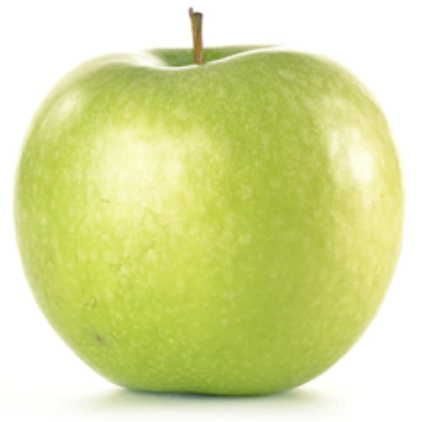

In [4]:
os.chdir('./dataset')
print(os.getcwd())
sampleimg = cv2.imread("./test/freshapples/Screen Shot 2018-06-08 at 5.03.40 PM.png")
print(sampleimg.shape)
cv2_imshow(sampleimg)

# **2. Data Preprocessing**

In [ ]:
# 이미지 데이터 셋을 만들기 위한 param 입력
batch_size = 32
img_height = 28
img_width = 28

In [ ]:
# data_dir 경로로부터 데이터 셋을 받아와서 분류 (seed는 shuffle에 사용되는 변수)
# 데이터에서 0.8은 train set용, 0.2는 validation set용
data_dir = "./train"
test_dir = "./test"

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size = batch_size,
    image_size = (img_height, img_width), #reshape if not in this size
    shuffle=True,
    seed=123,
    validation_split = 0.2,
    subset = "training"
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size = batch_size,
    image_size = (img_height, img_width), #reshape if not in this size
    shuffle=True,
    seed=123,
    validation_split = 0.2,
    subset = "validation"
)

test_set =  tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size = batch_size,
    image_size = (img_height, img_width), #reshape if not in this size
)

Found 4035 files belonging to 2 classes.
Using 3228 files for training.
Found 4035 files belonging to 2 classes.
Using 807 files for validation.
Found 996 files belonging to 2 classes.


In [ ]:
# 이미지 데이터셋의 미니배치 크기 및 레이블 크기 확인
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  img = cv2.cvtColor(image_batch[0].numpy(), cv2.COLOR_RGB2BGR)
  cv2_imshow(img)
  print(labels_batch.shape)
  print(labels_batch[0].numpy())
  break

(32, 28, 28, 3)


(32,)
1


In [ ]:
# train 속도 향상을 위한 prefetch 설정
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_validation = ds_validation.cache().prefetch(buffer_size=AUTOTUNE)

# **3-1. Create DNN Model**

In [ ]:
model = keras.Sequential([
                          keras.layers.Input((28, 28, 3)),
                          keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
                          keras.layers.MaxPool2D((2,2)),
                          keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
                          keras.layers.MaxPool2D((2,2)),
                          
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation='relu'),
                          keras.layers.Dense(128, activation='relu'),

                          keras.layers.Dense(1, activation='sigmoid') # binary classification
])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

history = model.fit(ds_train, validation_data = ds_validation, epochs=100, callbacks=[early_stopping_cb])

Epoch 1/100
101/101 [==============================] - 577s 6s/step - loss: 2.3942 - accuracy: 0.7193 - val_loss: 0.3198 - val_accuracy: 0.8761
Epoch 2/100
101/101 [==============================] - 1s 7ms/step - loss: 0.2738 - accuracy: 0.8934 - val_loss: 0.2098 - val_accuracy: 0.9108
Epoch 3/100
101/101 [==============================] - 1s 7ms/step - loss: 0.1713 - accuracy: 0.9325 - val_loss: 0.1510 - val_accuracy: 0.9368
Epoch 4/100
101/101 [==============================] - 1s 7ms/step - loss: 0.1493 - accuracy: 0.9393 - val_loss: 0.1606 - val_accuracy: 0.9318
Epoch 5/100
101/101 [==============================] - 1s 7ms/step - loss: 0.1168 - accuracy: 0.9560 - val_loss: 0.1295 - val_accuracy: 0.9393
Epoch 6/100
101/101 [==============================] - 1s 7ms/step - loss: 0.1080 - accuracy: 0.9557 - val_loss: 0.1012 - val_accuracy: 0.9579
Epoch 7/100
101/101 [==============================] - 1s 7ms/step - loss: 0.1255 - accuracy: 0.9492 - val_loss: 0.1194 - val_accuracy: 0.946

# **3-2. Create DNN Model (Hyperparameter Tuning)**

In [ ]:
def model_builder(hp):
  model_op = keras.Sequential()
  model_op.add(keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
  model_op.add(keras.layers.MaxPool2D((2,2)))
  model_op.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
  model_op.add(keras.layers.MaxPool2D((2,2)))
  model_op.add(keras.layers.Flatten())

  # unit 수 32 ~ 128까지 32개 단위로 최적화
  hp_units = hp.Int('units', min_value = 32, max_value = 128, step = 32)
  model_op.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model_op.add(keras.layers.Dense(128, activation = 'relu'))
  model_op.add(keras.layers.Dense(1, activation = 'sigmoid'))

  # learning rate 1e-2, 1e-3, 1e-4 중에서 최적화
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model_op.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  return model_op

In [ ]:
# Hyperband Optimization 정의
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10, # model 마다 비교하면서 epoch 진행시 최대로 진행할 epoch
                     factor=3, # 제거할 성능 미달의 model 수와 비교 시점의 epoch 결정 
                     directory='./hypertuning',
                     project_name='hp_best') # directory 하위 폴더, oracle.json, tuner0.json이 있다면 load 가능

INFO:tensorflow:Reloading Oracle from existing project ./hypertuning/hp_best/oracle.json
INFO:tensorflow:Reloading Tuner from ./hypertuning/hp_best/tuner0.json


In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

tuner.search(ds_train, validation_data = ds_validation, epochs=10, callbacks=[early_stopping_cb])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0] # best -> worst 순으로 항목이 num_trials 개수인 hp 리스트 반환, [0]이 best

print(f"""
The hyperparameter search is complete.
The optimal number of units in densely-connected layer is {best_hps.get('units')}
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in densely-connected layer is 128
The optimal learning rate for the optimizer is 0.001.


In [ ]:
# Optimal hyperparameters로 설정된 모델 학습
model_op = tuner.hypermodel.build(best_hps)
history_op = model_op.fit(ds_train, validation_data = ds_validation, epochs=100, callbacks=[early_stopping_cb])

Epoch 1/100
101/101 [==============================] - 567s 6s/step - loss: 1.2703 - accuracy: 0.7739 - val_loss: 0.3087 - val_accuracy: 0.8748
Epoch 2/100
101/101 [==============================] - 1s 7ms/step - loss: 0.2253 - accuracy: 0.9129 - val_loss: 0.2030 - val_accuracy: 0.9195
Epoch 3/100
101/101 [==============================] - 1s 7ms/step - loss: 0.1160 - accuracy: 0.9551 - val_loss: 0.1242 - val_accuracy: 0.9480
Epoch 4/100
101/101 [==============================] - 1s 7ms/step - loss: 0.1029 - accuracy: 0.9551 - val_loss: 0.1590 - val_accuracy: 0.9356
Epoch 5/100
101/101 [==============================] - 1s 7ms/step - loss: 0.1033 - accuracy: 0.9585 - val_loss: 0.2111 - val_accuracy: 0.9145
Epoch 6/100
101/101 [==============================] - 1s 7ms/step - loss: 0.1119 - accuracy: 0.9616 - val_loss: 0.1458 - val_accuracy: 0.9331


# **4. Results**

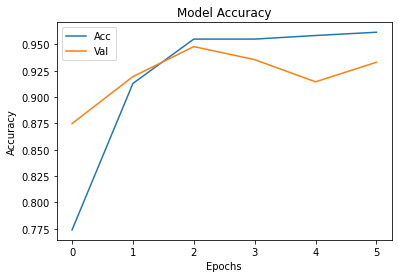

In [ ]:
plt.plot(history_op.history['accuracy'])
plt.plot(history_op.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Acc','Val'], loc = 'upper left')

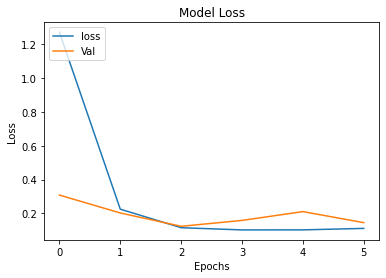

In [ ]:
plt.plot(history_op.history['loss'])
plt.plot(history_op.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','Val'], loc = 'upper left')

In [ ]:
# Test dataset
test_loss, test_acc = model_op.evaluate(test_set, verbose=2)

32/32 - 120s - loss: 0.0931 - accuracy: 0.9639 - 120s/epoch - 4s/step


# **5. Save Model**

In [ ]:
# ./saved_model/my_model 폴더 생성 후 저장
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


# **6. Load Model**

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

# **7. Test on Video**

In [ ]:
# 원본 영상 링크 : https://www.youtube.com/watch?v=4K0HSF2IS7o&list=WL&index=27

capture = cv2.VideoCapture("./test video/videoplayback.mp4")

capture_w = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
capture_h = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
capture_total_frame = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

fps = capture.get(cv2.CAP_PROP_FPS)

print("{0} x {1}".format(capture_w, capture_h))
print(capture_total_frame)
print(fps)

1280 x 720
9248
30.0


Apple is rotten!
0.10073686


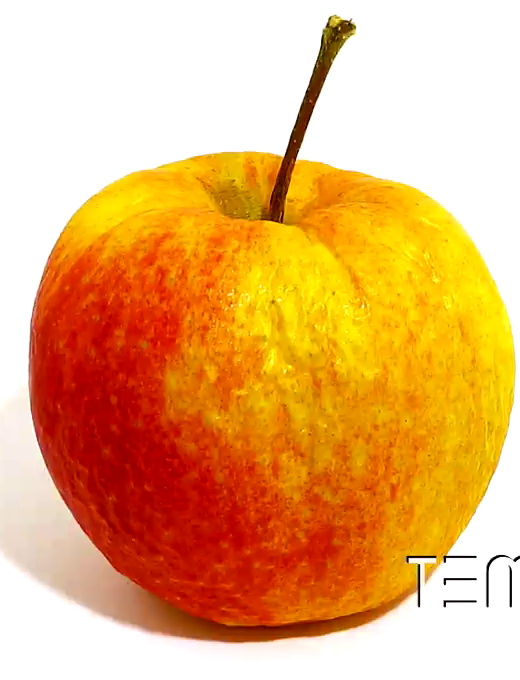

In [ ]:
# 영상에서 사과가 썩었다고 판단하면 결과 출력
capture.set(cv2.CAP_PROP_POS_FRAMES, 400)

for i in range(1, int(capture_total_frame)):
    run, frame1 = capture.read()
    frame = frame1[20:700, 380:900] # 영상에서 사과 부분의 roi 설정
    img = cv2.resize(frame, (28, 28))
    img = (np.expand_dims(img, 0))
    predictions_single = new_model.predict(img)
    output = predictions_single[0][0]
    if output > 0.1:
      print("Apple is rotten!")
      print(predictions_single[0][0])
      cv2_imshow(frame1)
      break